In [4]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import csv

from implementations import *
from helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users),
`ratings_` is an array type of `ratings`

In [5]:
#load the given ratings, build the sparse rating matrix, get the numbers of items and users
path_dataset = "dataset_train.csv"
ratings = load_data(path_dataset)
ratings_=ratings.toarray()
num_item, num_user = ratings.get_shape()

#load the indices of the missing ratings
path_submission = "dataset_submission.csv"
submission = extract_indices_submission(path_submission)
submission_row_col = submission[0]
submission_pos = submission[1]

number of items: 10000, number of users: 1000


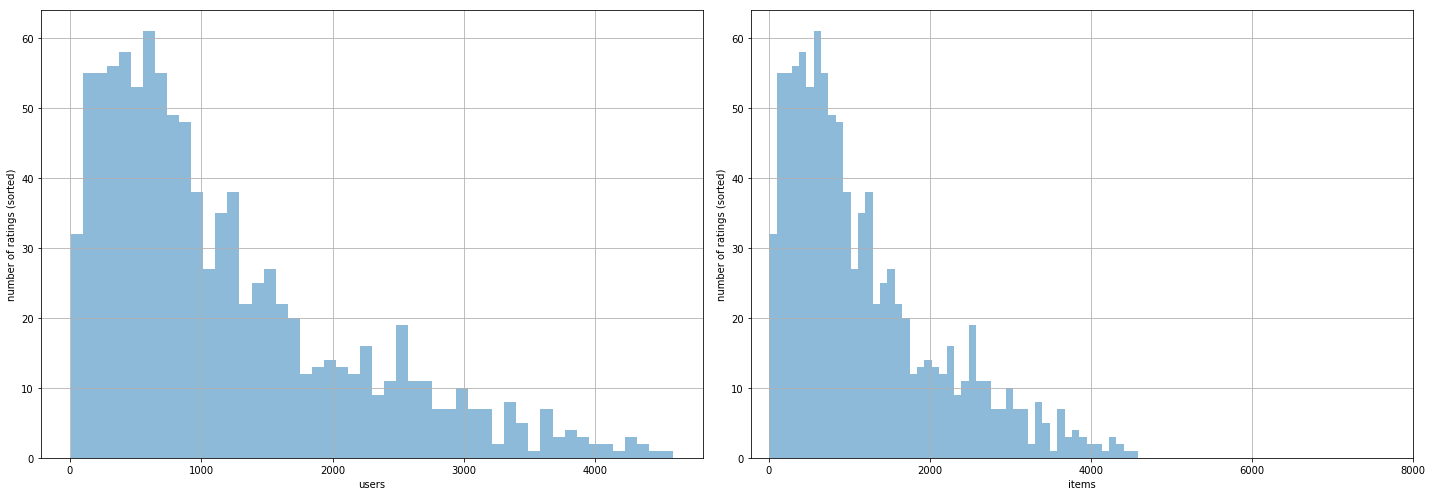

min # of items per user = 8, min # of users per item = 3.


In [6]:
from plots import plot_raw_data
#plot raw data
num_items_per_user, num_users_per_item = plot_raw_data(ratings)
print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Split data

In [7]:
def split_data(valid_ratings, p_test=0.1):
    """split the ratings to training data and test data. """
    # set seed
    np.random.seed(988)
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    #Return the indices of the elements that are non-zero.
    nz_items, nz_users = valid_ratings.nonzero() 

    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]
        
        # add to test set
        test[selects, user] = valid_ratings[selects, user]
        
    print("Total number of nonzero elements in origial data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return  train, test


Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065327
Total number of nonzero elements in test data:111625


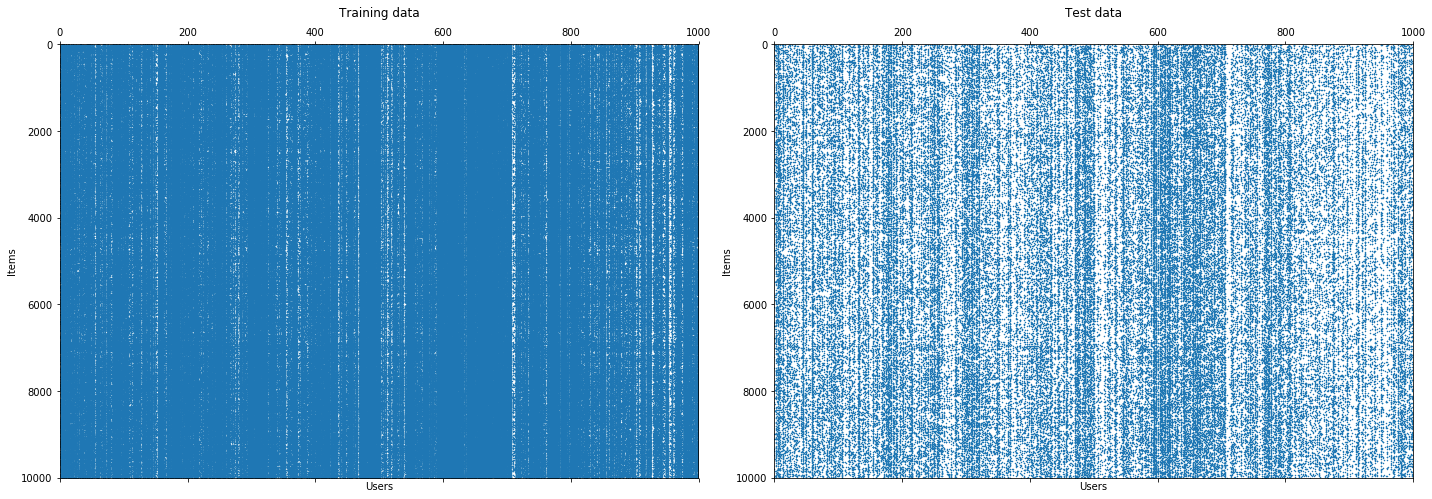

In [14]:
from plots import plot_train_test_data
train, test = split_data(ratings, p_test=0.1)
train_=train.toarray()
test_=test.toarray()
plot_train_test_data(train, test)

## Data preprocessing
### Extract means

In [70]:
def extract_user_mean(train):
    """calculate user mean"""
    user_nnz = train.getnnz(axis=0)
    user_sum = train.sum(axis=0)
    user_mean = np.empty((1, num_user))
    for ind in range(num_user):
        user_mean[0,ind] = user_sum[0,ind] / user_nnz[ind]
    return user_mean

def extract_global_mean(train):
    """calculate the global mean"""
    nonzero_train = train[train.nonzero()]
    global_mean = nonzero_train.mean()
    return global_mean

user_mean=extract_user_mean(train)
global_mean=extract_global_mean(train)

### Baseline estimate

In [71]:
# set the parameters
lamda_i = 10 
lamda_u = 15 
epochs = 10

#baseline_estimate, get the user effect bu and the item effect bi
bu,bi = baseline_estimate(train,lamda_i,lamda_u,epochs,global_mean)

### Similarity with Pearson coefficient

In [72]:
#set the parameters
min_support = 1
shrinkage = 1000

#pearson coefficient calculation
sim = user_based_similarity_by_pearson_baseline(train, min_support, global_mean, bu, bi, shrinkage)

NameError: name 'sim' is not defined

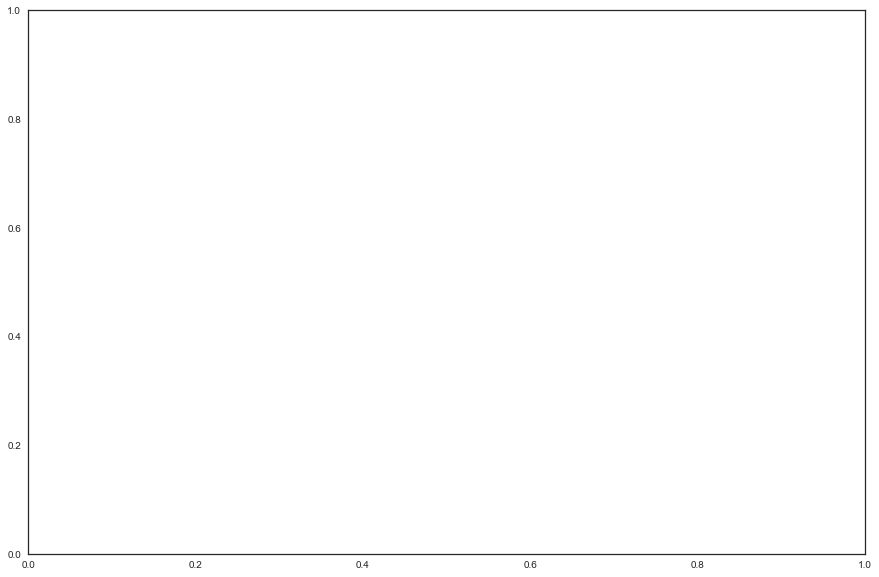

In [18]:
import seaborn as sns
import pandas as pd
from string import ascii_letters

np.random.seed(0)
sns.set()

#similarity matrix plot
sns.set(style="white")
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(sim,cmap=cmap, vmax=0.03,vmin=0, cbar_kws={"shrink": .5})


## KNN with means 

In [84]:
def knn_demo(train,test_row_col,nonzero_test,sim_matrix):
    """Prediction by KNN method, return the rmse for train or test data"""
    pred=[]    
    for row,col in test_row_col:
        i = row
        u = col
        est = KNN_with_user_means(train,sim_matrix,k,min_k,row,col,user_mean[0].T)
        pred.append(est)  
  
    error = nonzero_test-np.array(pred)
    rmse = np.sqrt( error.dot(error.T)/error.shape[1] )
    return rmse

In [85]:
#initial setting    
k = 200
min_k = 1

#extract the indices of nonzeros and check the prediction error for training data
train_row, train_col = train.nonzero()
train_row_col = list(zip(train_row, train_col))
nonzero_train = train[train.nonzero()].toarray()
rmse_train = knn_demo(train_,train_row_col,nonzero_train,sim)
print("RMSE of training data:{}".format(rmse_train))

#extract the indices of nonzeros and check the prediction error for testing data
test_row, test_col = test.nonzero()
test_row_col = list(zip(test_row, test_col))
nonzero_test = test[test.nonzero()].toarray()
rmse_test = knn_demo(train_,test_row_col,nonzero_test,sim)
print("RMSE of testing data:{}".format(rmse_test))

RMSE of training data:[[0.43488723]]
RMSE of testing data:[[1.03184241]]


## Predictions and  submission
### Prediction of KNN

In [88]:
pred_KNN=[]    
# the indices extracted from submission data start from 1, so we use row-1 and col-1
for row,col in submission_row_col:
    i=row-1
    u=col-1
    est= KNN_with_user_means(train_,sim,k,min_k,i,u,user_mean[0].T)
    pred_KNN.append(est)  

### Prediction of MF

In [12]:
#    for lambda_user in np.logspace(-2,0.5,20):
#        for lambda_item in np.logspace(-2,2,20):
#            print(lambda_user,' ', lambda_item)
lambda_user = 0.1
lambda_item = 0.7
user_features, item_features, user_bias, item_bias = matrix_factorization_SGD(train, test,0.01,lambda_user,lambda_item,100)
pred_MF = predict_MF(submission_row_col, user_features, item_features,user_bias,item_bias)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0323496983885811.
iter: 1, RMSE on training set: 1.020619066434164.
iter: 2, RMSE on training set: 1.0207570867151476.
iter: 3, RMSE on training set: 1.0216945970319502.
iter: 4, RMSE on training set: 1.0217952047319903.
iter: 5, RMSE on training set: 1.0194934774795832.
iter: 6, RMSE on training set: 1.0180395378905254.
iter: 7, RMSE on training set: 1.016110105954986.
iter: 8, RMSE on training set: 1.0149596599514072.
iter: 9, RMSE on training set: 1.0131700779774857.
RMSE on test data: 1.0277517021389888.


### Prediction of Kmeans

In [17]:
nb_times = 3
result = kmeans(train,train_,nb_times)
print("RMSE of testing data:{}".format(compute_error_Kmeans(test_,result)))
print("RMSE of training data:{}".format(compute_error_Kmeans(train_,result)))
pred_Kmeans = []
for row, col in submission_row_col:        
    pred_Kmeans.append(round(result[row-1,col-1])) 

The current iteration of k-means is: 0, the average loss is 928.756188272458.
The current iteration of k-means is: 1, the average loss is 873.1221666135706.
The current iteration of k-means is: 2, the average loss is 871.4523227529481.
The current iteration of k-means is: 3, the average loss is 862.6162260241783.
The current iteration of k-means is: 4, the average loss is 875.9341153622278.
The current iteration of k-means is: 5, the average loss is 876.02088573832.
The current iteration of k-means is: 6, the average loss is 876.0702900578484.
The current iteration of k-means is: 0, the average loss is 911.0709941536221.
The current iteration of k-means is: 1, the average loss is 860.2977310028167.
The current iteration of k-means is: 2, the average loss is 858.6149884938384.
The current iteration of k-means is: 3, the average loss is 868.2686614598257.
The current iteration of k-means is: 4, the average loss is 856.0002654231598.
The current iteration of k-means is: 5, the average los

KeyboardInterrupt: 

In [10]:
create_csv_submission(submission_pos, pred_MF, "prediction_recommender.csv")

In [ ]:
rmse_te[[1.03184241]]
rmse_tr[[0.43488723]]